## GIZA++ and MUSE - Machine Translation


### Tutorial Topics
- GIZA++ (word alignment model)
- MUSE (cross lingual word embedding model) 

### Software Requirements
- Python (>=3.6)
- Jupyter (latest)
- GIZA++ Needs:
    - Perl
    - OSX/Linux (recommended) or a Cygwin Terminal
    
If you are installing GIZA++ on Cygwin, make sure you have Perl, make, and GCC/G++ installed when you install Cygwin (default installation does not include these)


# GIZA++

[`GIZA++`](https://github.com/moses-smt/giza-pp) is an extension of the program `GIZA` (part of the SMT toolkit EGYPT) which was developed by the **Statistical Machine Translation team** during the summer workshop in 1999 at the Center for Language and Speech Processing at Johns-Hopkins University (CLSP/JHU). `Giza++` is an old and trusted resource for sentence alignment.  `Giza++` can be used to train word alignment models. `Giza++` supports [IBM Model](https://en.wikipedia.org/wiki/IBM_alignment_models) 1 to 5 (classic but most widely used unsupervised word alignment models to date). You can find more details [here](https://www.prhlt.upv.es/~evidal/students/master/sht/transp/giza2p.pdf). The extensions of `GIZA++` were designed and written by Franz Josef Och. 

A sample alignment between a English and German sentence might look like this:

![](./word_align.png)

# 1. Installation

**Step 1: Clone Giza++ from GitHub (https://github.com/moses-smt/giza-pp) to tutorial1 directory.**

```
git clone https://github.com/moses-smt/giza-pp.git
```

**Step 2: Amend `./giza-pp/GIZA++-v2/model3.cpp` for a case-insensitive file system (e.g., Windows or OS X). Change line 321 of model3.cpp to prevent the `.A3.final` file from being overwritten by the `.a3.final` file. Change as follows:**

- *remove*:  
    ```alignfile = Prefix + ".A3." + number ;```
- *add*:  
    ```alignfile = Prefix + ".VA3." + number ;```

**Step 3: Either using your Linux/Mac `terminal` or in your `Cygwin terminal`, navigate to the folder `./giza-pp` and run make.**

```
cd ./giza-pp
make
```

This should create the binaries `~/giza-pp/GIZA++-v2/GIZA++`, `~/giza-pp/GIZA++-v2/snt2cooc.out` and `~/giza-pp/mkcls-v2/mkcls`. If you get any warning, it is safe to be ignored. 

# 2. Download a Bilingual Corpus

To download a translated parallel bilingual corpora, visit http://www.statmt.org/europarl/ and download the Spanish-English corpus. Alternatively, the direct link to download is [download link](http://www.statmt.org/europarl/v7/es-en.tgz).

Once you unzip, you will have two files, one in L1 (in Spanish, file extension “.es”) and one in L2 (English, file extension “.en”). Then, we will put these two files to folder called `./europarl-es-en/`. We get:
```
./europarl-es-en/
   europarl-v7.es-en.en
   europarl-v7.es-en.es
```


Let's check some sample English-Spanish parallel texts: 

```
head -3 ./europarl-es-en/europarl-v7.es-en.*
```

```
==> ./europarl-es-en/europarl-v7.es-en.en <==
Resumption of the session
I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.
Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.

==> ./europarl-es-en/europarl-v7.es-en.es <==
Reanudación del período de sesiones
Declaro reanudado el período de sesiones del Parlamento Europeo, interrumpido el viernes 17 de diciembre pasado, y reitero a Sus Señorías mi deseo de que hayan tenido unas buenas vacaciones.
Como todos han podido comprobar, el gran "efecto del año 2000" no se ha producido. En cambio, los ciudadanos de varios de nuestros países han sido víctimas de catástrofes naturales verdaderamente terribles.
```

# 3. Preprocessing the Text

Before we use the dataset on Giza++, the parallel corpus must be tokenized. HTML notations needs to be cleaned.
We can do this using the **[moses decoder](https://github.com/moses-smt/mosesdecoder)**, part of the moses SMT package.

**3.1 Download the moses decoder by [cloning from this github repo](https://github.com/moses-smt/mosesdecoder) to tutorial1 directory.**

```
git clone https://github.com/moses-smt/mosesdecoder.git
```

**3.2 Tokenize each of the language pairs separately with moses by running:**

Note. Please change the directories to your corresponding directories.

```
./mosesdecoder/scripts/tokenizer/tokenizer.perl -l en < ./europarl-es-en/europarl-v7.es-en.en > ./europarl-es-en/europarl-v7.es-en.tok.en


./mosesdecoder/scripts/tokenizer/tokenizer.perl -l es < ./europarl-es-en/europarl-v7.es-en.es > ./europarl-es-en/europarl-v7.es-en.tok.es
```

When the tokenization process was complete, you can find two new files in directory `./europarl-es-en/`:
```
./europarl-es-en/
   europarl-v7.es-en.tok.en	
   europarl-v7.es-en.tok.es

```

Let's check some sample **tokenized** English-Spanish parallel texts: 

```
head -3 ./europarl-es-en/europarl-v7.es-en.tok.e*
==> ./europarl-es-en/europarl-v7.es-en.tok.en <==
Resumption of the session
I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999 , and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period .
Although , as you will have seen , the dreaded &apos; millennium bug &apos; failed to materialise , still the people in a number of countries suffered a series of natural disasters that truly were dreadful .

==> ./europarl-es-en/europarl-v7.es-en.tok.es <==
Reanudación del período de sesiones
Declaro reanudado el período de sesiones del Parlamento Europeo , interrumpido el viernes 17 de diciembre pasado , y reitero a Sus Señorías mi deseo de que hayan tenido unas buenas vacaciones .
Como todos han podido comprobar , el gran &quot; efecto del año 2000 &quot; no se ha producido . En cambio , los ciudadanos de varios de nuestros países han sido víctimas de catástrofes naturales verdaderamente terribles .
```

# 4. Creating the Input Files

We need three types of files to run Giza:
- a `.vcb` containing a list of vocabulary words for languages
- a `.snt` (sentence) file and
- a `.cooc`, or coocurrence file.

**We pass the files in the source language (in this case, Spanish) followed by the files in the target language (English).**

**4.1  To create the vocabulary file (`.vcb`) and sentence file (`.snt`) run:**


Note. Please change the directories to your corresponding directories.

```
./giza-pp/GIZA++-v2/plain2snt.out ./europarl-es-en/europarl-v7.es-en.tok.es ./europarl-es-en/europarl-v7.es-en.tok.en
```

After running, our `./europarl-es-en/` folder contain four more files:
```
./europarl-es-en/
   europarl-v7.es-en.tok.en_europarl-v7.es-en.tok.es.snt
   europarl-v7.es-en.tok.es_europarl-v7.es-en.tok.en.snt
   europarl-v7.es-en.tok.en.vcb
   europarl-v7.es-en.tok.es.vcb

```

**4.2 Create the cooccurrence (`.cooc`) file by running the following command.**

Note. Please change the directories to your corresponding directories.

```
./giza-pp/GIZA++-v2/snt2cooc.out ./europarl-es-en/europarl-v7.es-en.tok.es.vcb ./europarl-es-en/europarl-v7.es-en.tok.en.vcb ./europarl-es-en/europarl-v7.es-en.tok.es_europarl-v7.es-en.tok.en.snt > ./europarl-es-en/corp.cooc
```

After running, our `./europarl-es-en/` folder contain one more file:

```
./europarl-es-en/
   corp.cooc
   
```

**4.3 IBM Model 4 and 5 use word classes to model distortion - a concept to model how word order changes across languages. Then run mkcls which is a program to automatically infer word classes from a corpus using a maximum likelihood criterion:**
```
    ./giza-pp/mkcls-v2/mkcls -p./europarl-es-en/europarl-v7.es-en.tok.es -V./europarl-es-en/europarl-v7.es-en.tok.es.vcb.classes
    ./giza-pp/mkcls-v2/mkcls -p./europarl-es-en/europarl-v7.es-en.tok.en -V./europarl-es-en/europarl-v7.es-en.tok.en.vcb.classes
```


See the paper by [Franz Och](https://www.aclweb.org/anthology/E99-1010/) for the details of this word clustering.

After running, our `./europarl-es-en/` folder contain four more files:
```
./europarl-es-en/
    europarl-v7.es-en.tok.es.vcb.classes.cats
    europarl-v7.es-en.tok.es.vcb.classes
    europarl-v7.es-en.tok.en.vcb.classes.cats
    europarl-v7.es-en.tok.en.vcb.classes

```

# 5. Running Giza++

GIZA++ will output files so we recommend creating a new output directory `giza_output/`. Run the following command:

```
 ./GIZA++ -S [source.vcb] -T [target.vcb] -C [(source_target.snt) or (target_source.snt)] -CoocurrenceFile [file.cooc] -o [prefix] -outputpath [path to output directory]
```
For our case, the command should be:
```
./giza-pp/GIZA++-v2/GIZA++ -S ./europarl-es-en/europarl-v7.es-en.tok.es.vcb -T ./europarl-es-en/europarl-v7.es-en.tok.en.vcb -C ./europarl-es-en/europarl-v7.es-en.tok.es_europarl-v7.es-en.tok.en.snt -o en-es -CoocurrenceFile ./europarl-es-en/corp.cooc -outputpath ./europarl-es-en/giza_output/
```

The .VA3.final will be output in addition to other files. It contains sentence pairs and word alignments from the source language into the target language.


# Output example:

The following are examples I got using Spanish-English dataset. You can find these translated output from `en-es.VA3.final` file.

### Sentence pair (1) source length 5 target length 4 alignment score : 5.14289e-05
* Source: NULL ({ 3 }) Reanudación ({ 1 }) del ({ 2 }) período ({ }) de ({ }) sesiones ({ 4 })
* Translated Target: Resumption of the session
* Gold Target: Resumption of the session

### Sentence pair (4) source length 23 target length 21 alignment score : 8.95008e-31
*  Source: NULL ({ 7 12 13 }) Sus ({ 1 }) Señorías ({ }) han ({ 2 }) solicitado ({ 3 }) un ({ 4 }) debate ({ 5 }) sobre ({ 6 }) el ({ }) tema ({ 8 }) para ({ }) los ({ }) próximos ({ 14 15 }) días ({ 16 }) , ({ 17 }) en ({ 9 }) el ({ 10 }) curso ({ 11 18 }) de ({ }) este ({ 19 }) período ({ }) de ({ }) sesiones ({ 20 }) . ({ 21 })

* Translated Target: You have requested a debate on this subject in the course of the next few days , during this part-session .
* Gold Target: You have requested a debate on this subject in the course of the next few days, during this part-session.

### Sentence pair (6) source length 16 target length 12 alignment score : 1.45869e-22
*  Source: NULL ({ 3 5 9 }) Invito ({ 1 2 }) a ({ }) todos ({ }) a ({ }) que ({ }) nos ({ }) pongamos ({ 4 }) de ({ }) pie ({ }) para ({ 6 }) guardar ({ 7 }) un ({ }) minuto ({ 8 }) de ({ }) silencio ({ 10 11 }) . ({ 12 })
* Translated Target:  Please rise , then , for this minute &apos; s silence .
* Gold Target: Please rise, then, for this minute' s silence.


Let us take a look at these samples. 

The source language is Spanish:  `NULL ({ 3 }) Reanudación ({ 1 }) del ({ 2 }) período ({ }) de ({ }) sesiones ({ 4 })`.

The target language is English: `Resumption of the session`.

`NULL ({ 3 })` indicate that third token of target language doesn't align to any token of source language. 

`Reanudación ({ 1 })` indicate that the first token of target language align to `Reanudación` of source language.

`período ({ })` indicate that `período` of source language doesn't have any alignment in English.

In sentence pair (4), `NULL ({ 7 12 13 })` means the `7th (this) , 12th (of) , and 13th (the)` token of target sentence don't have alignment in Spanish. `próximos ({ 14 15 })` indicate that `14th (next) , 15th (few)` token of target sentence align to `próximos` of source language. 

Let us take a look at other important output files.

* File `en-es.trn.src.vcb` is the dictionary of source language on training set. It maps from source words to word IDs. In each row, first item is word ID; second item is token of source language; third item is the token frequency. 
* File `en-es.trn.trg.vcb` is dictionary of target language on training set. It maps from target words to word IDs. In each row, first item is word ID; second item is token of target language; third item is the token frequency.   

* File `en-es.t3.final` is translation table after all iterations that align source language with target language. First column is the ID of source language. Second column is the ID of target language. Third column is the probability of that alignment is given after each set of tokens. 

For example: In en-es.trn.src.vcb, the 31st row is `31 . 192152` that means the index of `'.'` token is 31, and its frequency is 192152 in source language (i.e., Spanish). 

Then, you can find the alignment of `'.'` in the translation table (i.e., en-es.t3.final): 

| src | trg | align       |
|-----|-----|-------------|
| 31  | 22  | 1.30462e-05 |
| 31  | 29  | 1.32761e-05 |
| 31  | 30  | 1.27958e-06 |
| 31  | 32  | 1.34422e-05 |
| 31  | 37  | 0.984368    |
| 31  | 39  | 7.68823e-05 |
| 31  | 44  | 2.97203e-05 |
| 31  | 50  | 4.78602e-06 |
| 31  | 63  | 4.65898e-05 |

Then, this table converted to:

| src | trg | align       |
|-----|-----|-------------|
| .  | again  | 1.30462e-05 |
| .  | year  | 1.32761e-05 |
| .  | in  | 1.27958e-06 |
| .  | that  | 1.34422e-05 |
| .  | .  | 0.984368    |
| .  | as  | 7.68823e-05 |
| .  | &apos;  | 2.97203e-05 |
| .  | people  | 4.78602e-06 |
| .  | this  | 4.65898e-05 |

You can see that the best alignment of source `'.'` is the target `'.'`. This alignment obtain the highest probability.

# [MUSE: Multilingual Unsupervised and Supervised Embeddings](https://research.fb.com/downloads/muse-multilingual-unsupervised-and-supervised-embeddings/)

MUSE is a Python library for multilingual word embeddings, whose goal is to provide the community with:

* state-of-the-art multilingual word embeddings based on [fastText](https://github.com/facebookresearch/fastText)
* large-scale high-quality bilingual dictionaries for training and evaluation

MUSE includes two methods, one `supervised` that uses a bilingual dictionary or identical character strings, and one `unsupervised` that does not use any parallel data (see paper [Word Translation without Parallel Data](https://arxiv.org/pdf/1710.04087.pdf) for more details).

![](./outline_all.png)

You can align any bilingual word embeddings using MUSE package. You can explore the training process [here](https://github.com/facebookresearch/MUSE).

MUSE released their fastText embeddings that have been aligned in a common space [here](https://github.com/facebookresearch/MUSE#download). Let us download [English](https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.en.vec) and [Spanish](https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.es.vec) word embeddings.

In the rest of this tutorial, we will focus on loading these embeddings, identify words most similar to a given word in the same language and the other language.

# Required packages

In [23]:
import io
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

**Create a function that loads a word vector file into memory and returns word embeddings, identifier to word and word to identifier mapping**

In [24]:
def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f) # skips the first line
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

Load both english and spanish word embeddings (max. $50K$ in each language):

In [25]:
src_path = './muse/wiki.multi.en.vec'
tgt_path = './muse/wiki.multi.es.vec'
nmax = 50000  # maximum number of word embeddings to load

src_embeddings, src_id2word, src_word2id = load_vec(src_path, nmax)
tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(tgt_path, nmax)

We can check the shapes of english and spanish embeddings:

In [26]:
print("Shape of English word embeddings = ", src_embeddings.shape)
print("Shape of Spanish word embeddings = ", tgt_embeddings.shape)

Shape of English word embeddings =  (50000, 300)
Shape of Spanish word embeddings =  (50000, 300)


**We will use [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) to measure the similarity between two word embedding vectors. The formula of cos similarity is:**

$similarity = cos(\theta) = \frac{A \cdot B}{||A|| ||B||} = \frac{\sum_{i=1}^{d} A_iB_i}{\sqrt{\sum_{i=1}^{d} A^2_i}\sqrt{\sum_{i=1}^{d} B^2_i}}$

**Now, we assume A is the vector of `cat` in English and B is the vector of `dog` in English.**

In [27]:
A = src_embeddings[src_word2id['cat']] # word embedding of 'cat' in English word embedding space
B = src_embeddings[src_word2id['dog']] # word embedding of 'dog' in English word embedding space
print("Shape of 'cat' word embedding = ", A.shape)
print("Shape of 'dog' word embedding = ", B.shape)
cos_sim = np.dot(A, B) / np.linalg.norm(A) * np.linalg.norm(B)
print("cosine similarity (cat, dog) = ",cos_sim)

Shape of 'cat' word embedding =  (300,)
Shape of 'dog' word embedding =  (300,)
cosine similarity (cat, dog) =  0.6380516990078948


**Alternatively, we can use the `cosine_similarity` function from sklearn.**

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
#  the shape of A and B must be (n_samples_X, n_features). Hence we reshape the A and B vectors.
print("cosine similarity (cat, dog) = ", cosine_similarity(A.reshape(1, -1), B.reshape(1, -1))) 

cosine similarity (cat, dog) =  [[0.63805158]]


**Let's print the 5 nearest neighbors of the word `cat` in English word embedding space.**

In [29]:
# get all similarity scores between cat and all the tokens in English vocabulary. 
all_scores = cosine_similarity(src_embeddings, A.reshape(1, -1))
print("Similarity of word cat with all words in English vocabulary (shape) = ", all_scores.shape)

# reshape (num_vocabulary, 1) to (num_vocabulary)
all_scores = np.squeeze(all_scores,axis=1)
print("Similarity of word cat with all words in English vocabulary (shape after removing extra dimension) = ", all_scores.shape)

# get indices of the 5 nearest neighbors
top5_ind = all_scores.argsort()[-5:][::-1]
print("Word indices of five nearest neighbors of word cat = ", top5_ind)

# convert the indices to actual tokens
print("Similarity - word (word id)")
for i, idx in enumerate(top5_ind):
    print('%.4f - %s (%d)' % (all_scores[idx], src_id2word[idx], idx))

Similarity of word cat with all words in English vocabulary (shape) =  (50000, 1)
Similarity of word cat with all words in English vocabulary (shape after removing extra dimension) =  (50000,)
Word indices of five nearest neighbors of word cat =  [ 2570  4939 25570  2344 36108]
Similarity - word (word id)
1.0000 - cat (2570)
0.7322 - cats (4939)
0.6453 - kitten (25570)
0.6381 - dog (2344)
0.6218 - kittens (36108)


**Let's buid a function to get the $n$ nearest neighbors of given word.**

In [30]:
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
    print("Nearest neighbors of \"%s\":" % word)
    # create to map word to index
    word2id = {v: k for k, v in src_id2word.items()}
    # get the word embedding of give word 
    word_emb = src_emb[word2id[word]]
    # get all similarity scores between given word and all the tokens in target vocabulary. 
    scores = np.squeeze(cosine_similarity(tgt_emb, word_emb.reshape(1, -1)),axis=1)
    # get indices of the n nearest neighbors
    k_best = scores.argsort()[-K:][::-1]
    # convert the indices to actual tokens
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

**Let's print nearest neighbors of the English word *cat* in the English word embedding space again using *get_nn* function.**

In [31]:
# printing nearest neighbors in the source space (English), results will be identical to the previous query
src_word = 'cat'
get_nn(src_word, src_embeddings, src_id2word, src_embeddings, src_id2word, K=5)

Nearest neighbors of "cat":
1.0000 - cat
0.7322 - cats
0.6453 - kitten
0.6381 - dog
0.6218 - kittens


**Let's print nearest neighbors of the English word *king* in the English word embedding space again using *get_nn* function.**

In [32]:
# printing nearest neighbors in the source space (English)
src_word = 'king'
get_nn(src_word, src_embeddings, src_id2word, src_embeddings, src_id2word, K=5)

Nearest neighbors of "king":
1.0000 - king
0.6762 - kings
0.6493 - queen
0.6260 - monarch
0.5978 - kingship


**Let's print nearest neighbors of the English word *cat* in the Spanish word embedding space again using *get_nn* function.**

Note that the fourth and fifth argument to the function should be Spanish identifier to word mapping and Spanish word embeddings respectively.

In [33]:
# printing nearest neighbors of a word in source language (English) in the target space (Spanish)
# if the quality of the embeddings is good, this query can provide the translation for the word in the target language
src_word = 'cat'
get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=5)

Nearest neighbors of "cat":
0.6165 - gato
0.5401 - perro
0.4849 - conejo
0.4839 - gorila
0.4746 - felino


**Let's print nearest neighbors of the English word *king* in the Spanish word embedding space again using *get_nn* function.**

In [34]:
# printing nearest neighbors in the target space (Spanish)
src_word = 'king'
get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=5)

Nearest neighbors of "king":
0.8047 - rey
0.6728 - monarca
0.6187 - reina
0.5814 - reinar
0.5755 - reyes


# Visualize multilingual embeddings

In order to visualize the word embeddings in 2 dimensional space, we will use PCA to map word embeddings from 300 dimensions to 2 dimensions.

Let's fit PCA on the concatenation of English and Spanish word embeddings.

In [35]:
from sklearn.decomposition import PCA
# instantiate a PCA object which includes two components
pca = PCA(n_components=2, whiten=True)
# use PCA object on src_embeddings and tgt_embeddings
pca.fit(np.vstack([src_embeddings, tgt_embeddings]))
# how much variance of orignial embeddings (300 dimensions) is explained in PCA components (2 dimensions)?
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

Variance explained: 0.06


**Let's use matplotlib machinery to build a function `plot_similar_word` that takes a list of English and Spanish words and plot them in a single multilingual word embedding space.**

In [36]:
import matplotlib.pyplot as plt

def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()

Let's pick some sample English and Spanish words (that are present in our vocabulary) and call the *plot_similar_word* function to create the visualization of all the words in a single multilingual word embedding space.

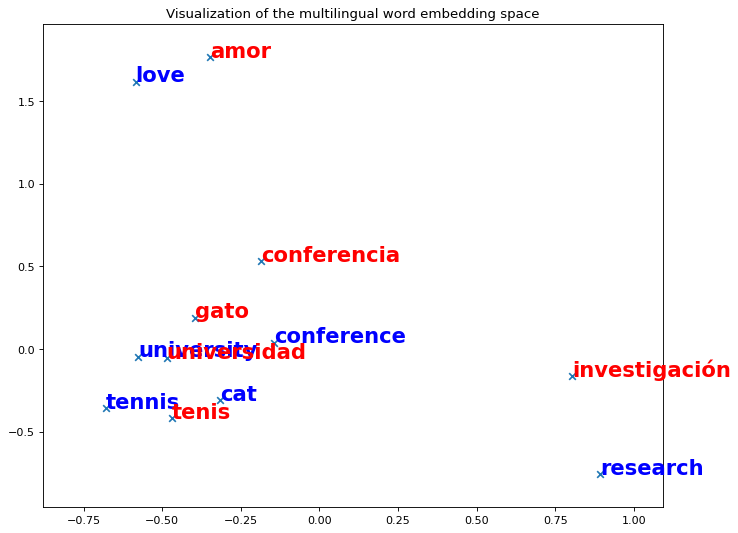

In [37]:
# get 5 random input words
src_words = ['university', 'love', 'cat', 'tennis', 'research', 'conference']
tgt_words = ['universidad', 'amor', 'gato', u'tenis',  u'investigación', 'conferencia']

# assert words in dictionaries
for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in tgt_word2id, '"%s" not in target dictionary' % sw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, tgt_word2id, tgt_embeddings, pca)

# Reference 
* https://medium.com/@weGotlieb/using-giza-for-bilingual-sentence-alignment-8b2dc828a04d
* http://www.statmt.org/moses/?n=Moses.Baseline
* https://www.aclweb.org/anthology/E99-1010/
* http://masatohagiwara.net/using-giza-to-obtain-word-alignment-between-bilingual-sentences.html
* https://okapiframework.org/wiki/index.php/GIZA%2B%2B_Installation_and_Running_Tutorial
* https://www.ijert.org/research/word-alignment-using-giza-and-cygwin-on-windows-IJERTV2IS50775.pdf
* https://github.com/facebookresearch/MUSE/blob/master/demo.ipynb